In [ ]:
import fastf1 as ff1
import pandas as pd
from fastf1.core import Laps
from fastf1 import plotting
from fastf1 import utils
from matplotlib import pyplot as plt
from timple.timedelta import strftimedelta
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm


ff1.Cache.enable_cache('GB2023') 
fp = ff1.get_session(2023, 'Great Britain', 'FP2')
#fp_laps = fp.load_laps(with_telemetry=True)
fp.load()

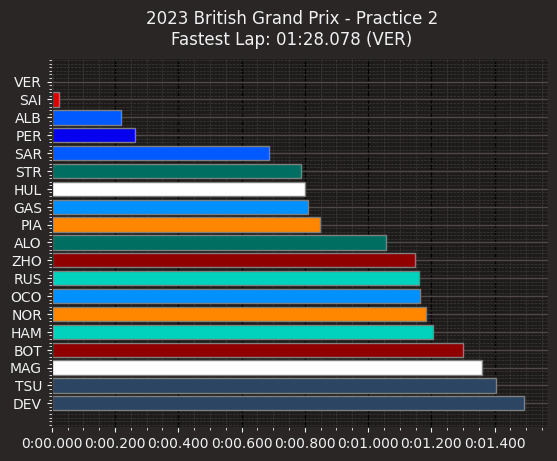

In [2]:
drivers = pd.unique(fp.laps['Driver'])
best_laps = list()
for driver in drivers:
    best_laps.append(fp.laps.pick_driver(driver).pick_fastest())
fastest_laps = Laps(best_laps).sort_values(by='LapTime').reset_index(drop=True)

pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

team_colors = list()
for index, lap in fastest_laps.iterlaps():
        color = ff1.plotting.team_color(lap['Team'])
        team_colors.append(color)
        
ff1.plotting.setup_mpl()
fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')

plt.suptitle(f"{fp.event.year} {fp.event.EventName} - {fp.name}\n"
             f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

plt.show()

C:\Users\ricca\AppData\Local\Temp\ipykernel_9584\1509926956.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merge = fastest_drv1.append(fastest_drv3)
C:\Users\ricca\AppData\Local\Temp\ipykernel_9584\1509926956.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = merge.append(fastest_drv2)


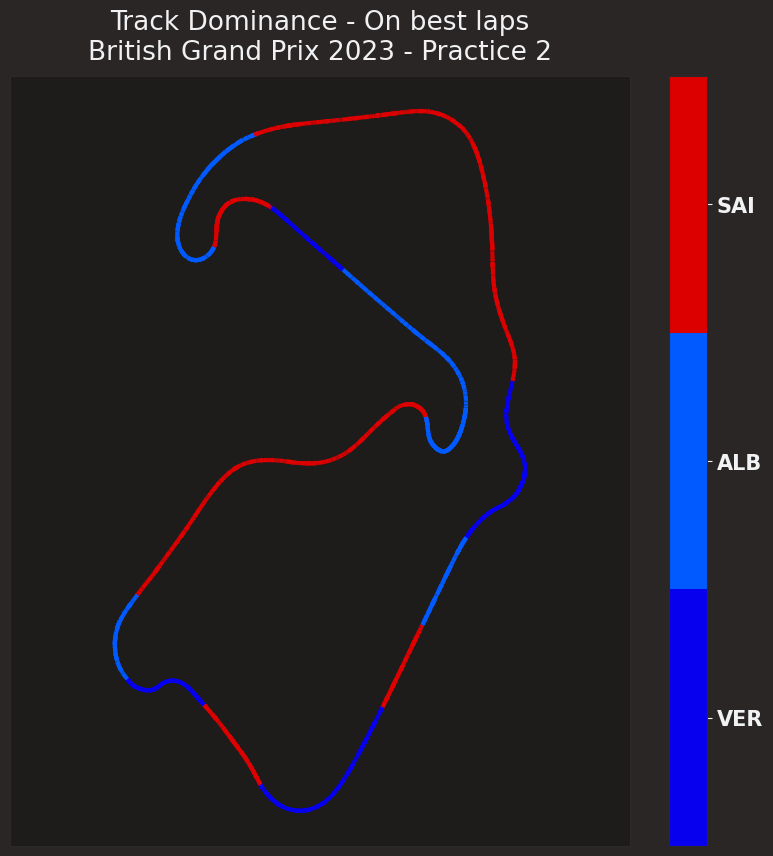

In [3]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
plotting.setup_mpl()
fp_laps = fp.laps
driver1='VER'
driver2='SAI'
driver3='ALB'

color_drv1 = ff1.plotting.team_color('RBR')
color_drv2 = ff1.plotting.team_color('FER')
color_drv3 = ff1.plotting.team_color('WIL')

laps_drv1 = fp_laps.pick_driver(driver1)
laps_drv2 = fp_laps.pick_driver(driver2)
laps_drv3 = fp_laps.pick_driver(driver3)


fastest_drv1 = laps_drv1.pick_fastest().get_telemetry().add_distance()
fastest_drv2 = laps_drv2.pick_fastest().get_telemetry().add_distance()
fastest_drv3 = laps_drv3.pick_fastest().get_telemetry().add_distance()

fastest_drv1['Driver'] = driver1
fastest_drv2['Driver'] = driver2
fastest_drv3['Driver'] = driver3

merge = fastest_drv1.append(fastest_drv3)
telemetry = merge.append(fastest_drv2)

#We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

# Grab the maximum value of distance that is known in the telemetry
total_distance = total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))


telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == driver1, 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == driver3, 'Fastest_driver_int'] = 2
telemetry.loc[telemetry['Fastest_driver'] == driver2, 'Fastest_driver_int'] = 3


x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

#cmap = cm.get_cmap('cool', 4)
cmap = ListedColormap([color_drv1, color_drv3, color_drv2])
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(3)

plt.rcParams['figure.figsize'] = [10, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.title(f"Track Dominance - On best laps\n"
          f"{fp.event['EventName']} {fp.event.year} - {fp.name}")
cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,5))
cbar.set_ticks(np.arange(1.5, 4.5))
cbar.set_ticklabels([driver1, driver3, driver2], fontsize=15, fontweight = 'bold')

plt.show()

c:\Users\ricca\OneDrive\Desktop\F1dataAnalysis\env\Lib\site-packages\fastf1\utils.py:81: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
c:\Users\ricca\OneDrive\Desktop\F1dataAnalysis\env\Lib\site-packages\fastf1\utils.py:81: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"
c:\Users\ricca\OneDrive\Desktop\F1dataAnalysis\env\Lib\site-packages\fastf1\utils.py:81: FutureWarning: `utils.delta_time` is considered deprecated and willbe modified or removed in a future release because it hasa tendency to give inaccurate results.
  warnings.warn("`utils.delta_time` is considered deprecated and will"


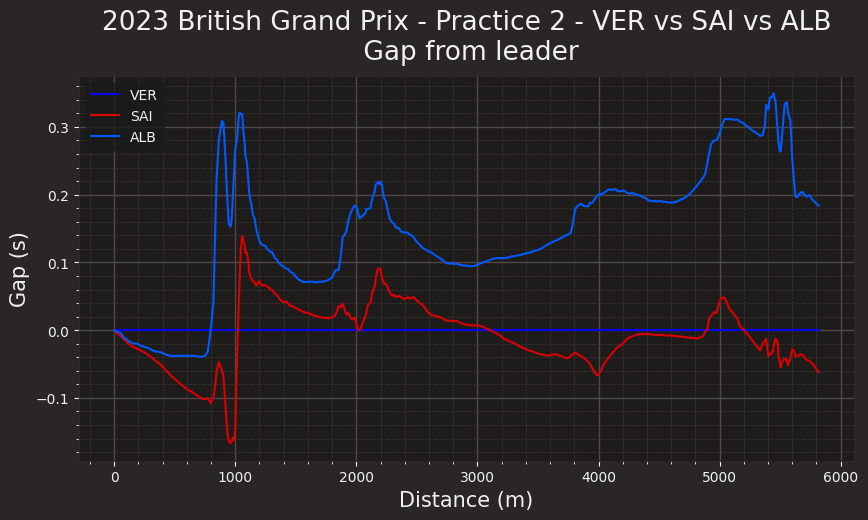

In [23]:
driver_1, driver_2, driver_3 = 'VER', 'SAI', 'ALB'
laps_driver_1 = fp.laps.pick_driver(driver_1)
laps_driver_2 = fp.laps.pick_driver(driver_2)
laps_driver_3 = fp.laps.pick_driver(driver_3)

fastest_driver_1 = laps_driver_1.pick_fastest()
fastest_driver_2 = laps_driver_2.pick_fastest()
fastest_driver_3 = laps_driver_3.pick_fastest()

telemetry_driver_1 = fastest_driver_1.get_telemetry().add_distance()
telemetry_driver_2 = fastest_driver_2.get_telemetry().add_distance()
telemetry_driver_3 = fastest_driver_3.get_telemetry().add_distance()

team_driver_1 = fastest_driver_1['Team']
team_driver_2 = fastest_driver_2['Team']
team_driver_3 = fastest_driver_3['Team']

delta_time12, ref_tel12, compare_tel12 = utils.delta_time(fastest_driver_1, fastest_driver_2)
delta_time13, ref_tel13, compare_tel13 = utils.delta_time(fastest_driver_1, fastest_driver_3)
delta_time11, ref_tel11, compare_tel11 = utils.delta_time(fastest_driver_1, fastest_driver_1)

plot_size = [10, 5]
plot_title = f"{fp.event.year} {fp.event.EventName} - {fp.name} - {driver_1} vs {driver_2} vs {driver_3}\n Gap from leader"
plot_ratios = [1]
plotting.setup_mpl()
# Make plot a bit bigger
plt.rcParams['figure.figsize'] = plot_size

# Create subplots with different sizes
fig, ax = plt.subplots(1, gridspec_kw={'height_ratios': plot_ratios})

# Set the plot title
ax.title.set_text(plot_title)

# Delta line
ax.plot(ref_tel11['Distance'], delta_time11, color=ff1.plotting.team_color(team_driver_1), label= driver_1)
ax.plot(ref_tel12['Distance'], delta_time12, color=ff1.plotting.team_color(team_driver_2), label= driver_2)
ax.plot(ref_tel13['Distance'], delta_time13, color=ff1.plotting.team_color(team_driver_3), label = driver_3)

#ax.text(4400, 0, str(fastest_driver_1.LapTime)[10:19], fontsize=10, bbox=dict(boxstyle='round', facecolor=ff1.plotting.team_color(team_driver_1), alpha=0.5))
#ax.text(4400, 0.36, str(fastest_driver_2.LapTime)[10:19], fontsize=10, bbox=dict(boxstyle='round', facecolor=ff1.plotting.team_color(team_driver_2), alpha=0.5))
#ax.text(4400, 1.45, str(fastest_driver_3.LapTime)[10:19], fontsize=10, bbox=dict(boxstyle='round', facecolor=ff1.plotting.team_color(team_driver_3), alpha=0.5))

ax.set_ylabel("Gap (s)", fontsize = 10)
ax.set_xlabel("Distance (m)", fontsize=10)
ax.yaxis.label.set_size(15)
ax.xaxis.label.set_size(15)
ax.legend(loc="upper left", prop={'size': 10})

Text(0.5, 1.0, 'Fastest lap comparison\n2023 British Grand Prix - Practice 2\nVER - SAI')

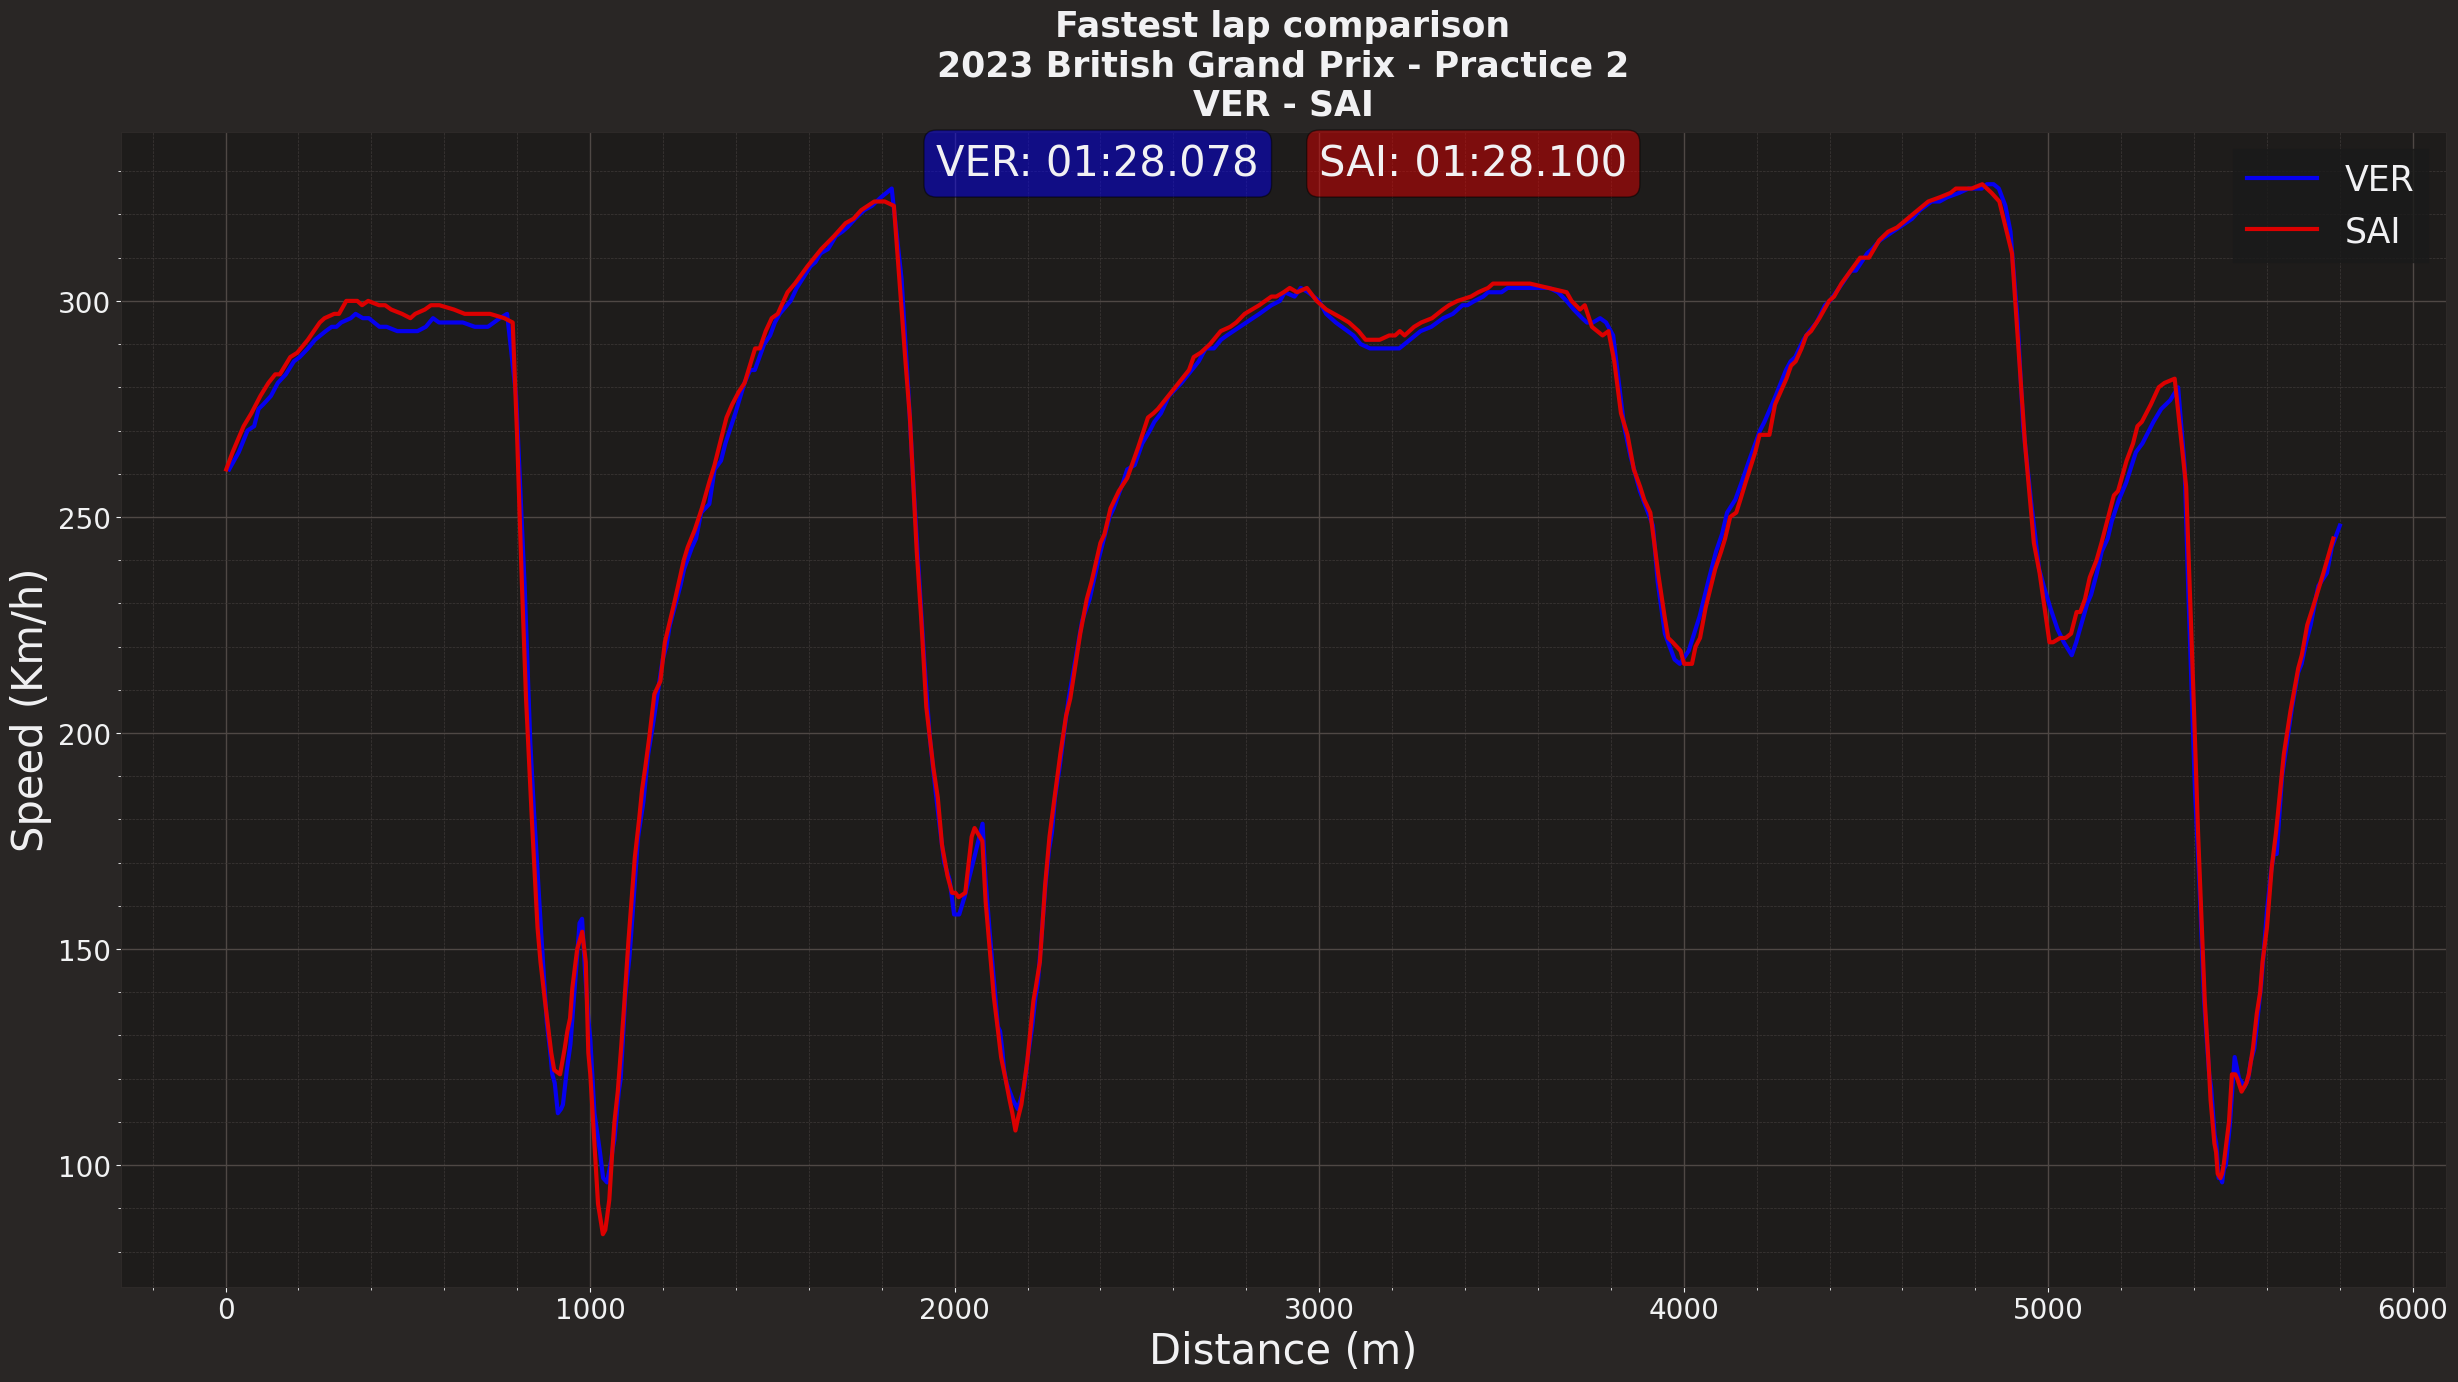

In [32]:
import matplotlib.pyplot as plt
import fastf1.plotting
from math import pi

ff1.plotting.setup_mpl()

ver_lap = fp.laps.pick_driver("VER").pick_fastest()
lec_lap = fp.laps.pick_driver('SAI').pick_fastest()

ver_tel = ver_lap.get_car_data().add_distance()
lec_tel = lec_lap.get_car_data().add_distance()

mer_color = ff1.plotting.team_color('RBR')
mer_color2 = ff1.plotting.team_color('FER')

fig1, ax1 = plt.subplots(1)
fig1.set_figheight(15)
fig1.set_figwidth(30)
ax1.plot(ver_tel['Distance'], ver_tel['Speed'], color = mer_color, label = 'VER', linewidth=3)
ax1.plot(lec_tel['Distance'], lec_tel['Speed'], color = mer_color2, label = 'SAI', linewidth=3)

ax1.text(1950, 329, "VER: "+str(ver_lap.LapTime)[10:19], fontsize=30, bbox=dict(boxstyle='round', facecolor=mer_color, alpha=0.5))
ax1.text(3000, 329, "SAI: "+str(lec_lap.LapTime)[10:19],  fontsize=30, bbox=dict(boxstyle='round', facecolor=mer_color2, alpha=0.5))

ax1.set_xlabel('Distance (m)', size=30)
ax1.set_ylabel('Speed (Km/h)', size=30)
ax1.tick_params(labelsize=20)
ax1.legend(prop={'size': 25})

plt.title(f"Fastest lap comparison\n"f"{fp.event.year} {fp.event.EventName} - {fp.name}\n{ver_lap['Driver']} - {lec_lap['Driver']}", size = 25, weight='bold', ha='center')
